In [18]:
%reload_ext autoreload
%autoreload 2

from pyneurode.spike_sorter import *
import numpy as np 
import pickle
from sklearn import metrics
from tqdm.notebook import tqdm
import seaborn as sns
from utils import *
from RingBuffer import RingBuffer
from sklearn import preprocessing
from sklearn import *
from scipy import signal 


In [3]:
agg_buffer = RingBuffer.readPickleStreamFile('../data/agg_buffer.pkl')

Total segment read: 160


(1760, 14)


(0.0, 2000.0)

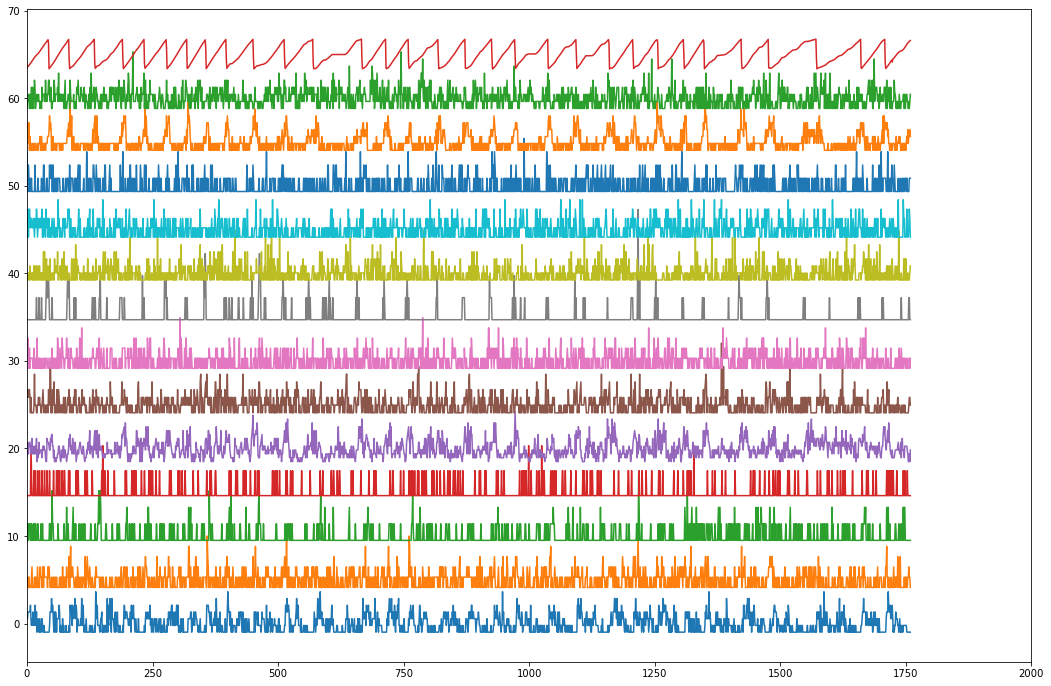

In [4]:
plt.figure(figsize=(18,12))
# signal2plot=np.hstack([norm_spiketrain,norm_pos_online])
scaler =preprocessing.StandardScaler()
print(agg_buffer.shape)
norm_agg_buffer = scaler.fit_transform(agg_buffer)

plot_multichannel(norm_agg_buffer.T,scale=5)
plt.xlim([0,2000])

### Decode

0.3508846739092104 0.3508847123460006 0.2893987663523617


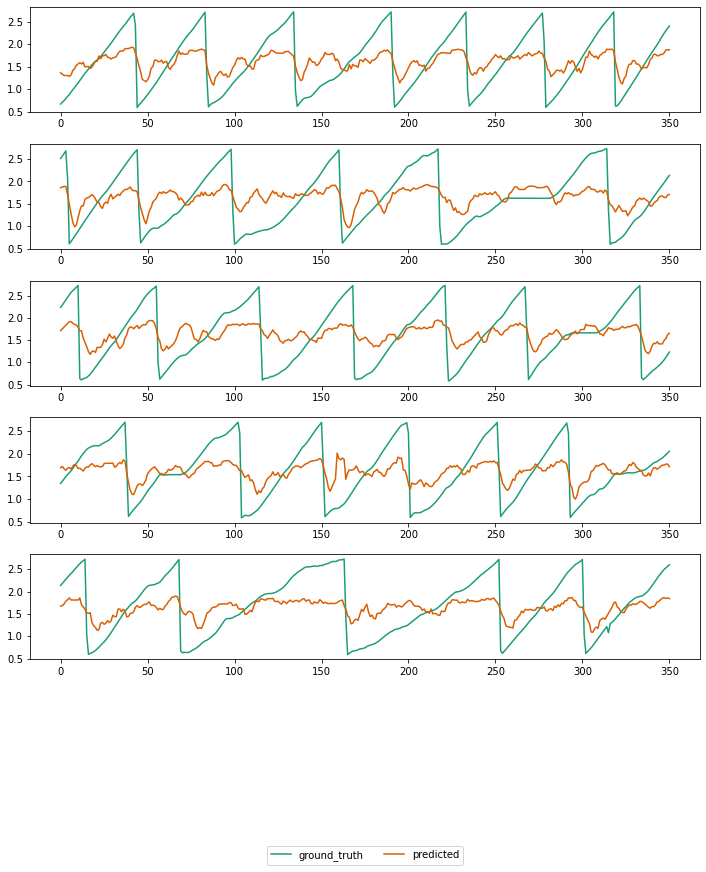

In [35]:

spk_train = agg_buffer[:,:-1]
pos = agg_buffer[:,-1]

scaler =preprocessing.StandardScaler()
norm_spk_train = scaler.fit_transform(spk_train)


polyFeatures = preprocessing.PolynomialFeatures(2).fit(norm_spk_train)
poly_spiketrain = polyFeatures.transform(norm_spk_train)

regressor = linear_model.Lasso(alpha=0.1).fit(poly_spiketrain,pos)

predicted = model_selection.cross_val_predict(regressor,poly_spiketrain,pos.ravel(),cv=4)
# predicted = model_selection.cross_val_predict(regressor,poly_spiketrain_ms4,norm_pos_online,cv=4)
predicted_smooth = signal.savgol_filter(predicted.ravel(),5,1)
r2 = metrics.r2_score(pos.squeeze(),predicted_smooth.ravel())
varExplain = metrics.explained_variance_score(pos.squeeze(),predicted_smooth.ravel())
varExplainRaw = metrics.explained_variance_score(pos.squeeze(),predicted.ravel())

print(r2,varExplain,varExplainRaw)
stripplot(pos,predicted_smooth,figsize=(12,12));


### Effect of training samples

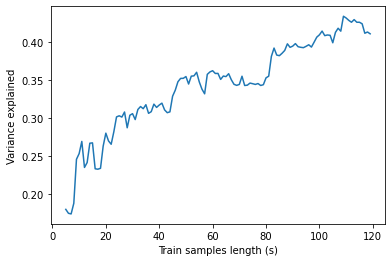

In [34]:
scores = []
data_length = []
time_bin = 0.1
# regressor = linear_model.Lasso(alpha=0.1)
regressor = svm.SVR(kernel='rbf',C=50,gamma='auto')
train_num_list = range(5,120)

polyFeatures = preprocessing.PolynomialFeatures(2).fit(norm_spk_train)
poly_spiketrain = polyFeatures.transform(norm_spk_train)

for train_num in train_num_list:
    #create training and testing set
    train_idx = range(int(train_num*(1/time_bin)))
    test_idx = np.setdiff1d(range(poly_spiketrain.shape[0]),train_idx)
    assert len(np.intersect1d(train_idx,test_idx)) == 0
    
    # fit and predict
    regressor.fit(poly_spiketrain[train_idx,:], pos[train_idx])
    predicted = regressor.predict(poly_spiketrain[test_idx,:])

    predicted_smooth = signal.savgol_filter(predicted.ravel(),5,1)
    varExplain = metrics.explained_variance_score(pos[test_idx],predicted_smooth)
    
    scores.append(varExplain)

plt.plot(train_num_list, scores)
plt.xlabel('Train samples length (s)')
plt.ylabel('Variance explained');

### Do some feature selection as well as parameter search